In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

from caiman.utils.utils import load_dict_from_hdf5

2025-07-09 11:26:50.016361: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 11:26:50.205573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


40


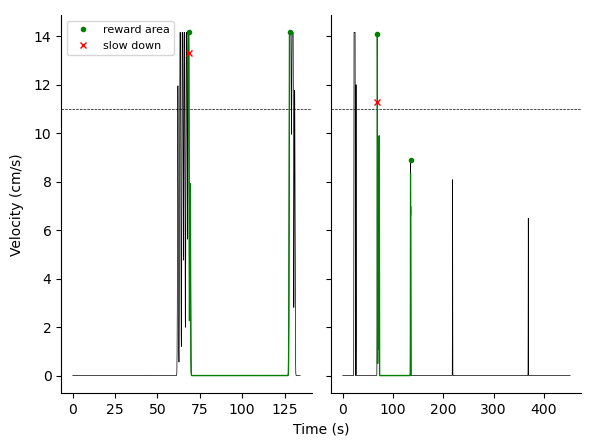

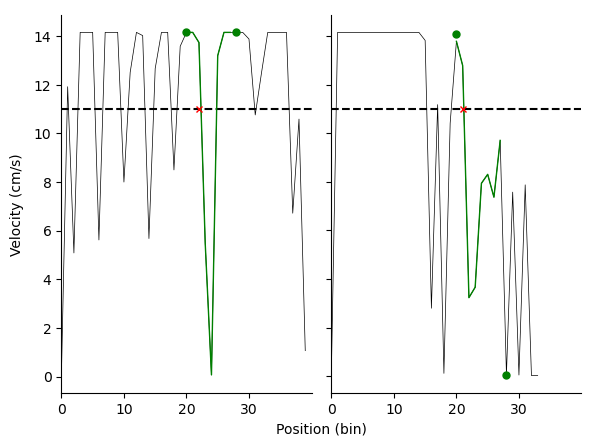

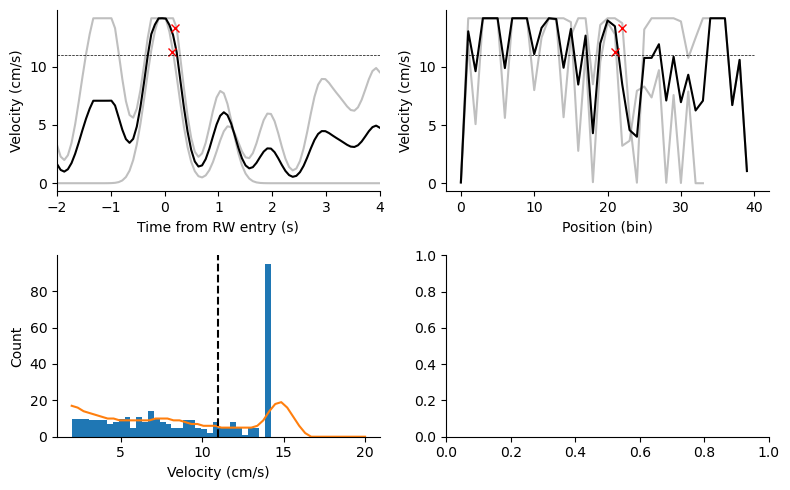

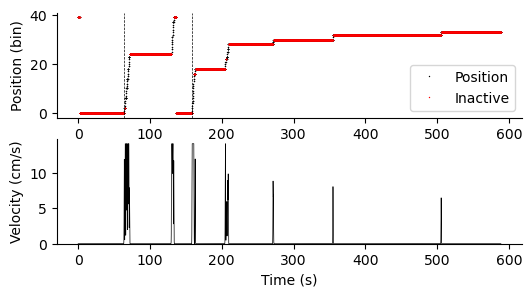

In [7]:
from placefield_detection.utils import prepare_behavior_from_file, plot_behavior

pathMouse = Path("../../../../data/845ad")
pathSession = pathMouse / "Session01"
f = 15.0
nbin = 40
only_active = True

pathBehavior = pathSession / "aligned_behavior.pkl"
behavior = prepare_behavior_from_file(
    pathBehavior,
    only_active=only_active,
    environment_length=120.0,
    nbin=nbin,
    f=15.0,
    T=None,
    calculate_performance=True,
    plt_bool=True,
    plt_trials=True,
)


plot_behavior(behavior)

In [4]:
behavior["performance"]

{'RW_reception': array([ True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 'RW_frame': array([  44,  285,  519,  785, 1025, 1272, 1621, 1813,    0, 2407, 2852,
        3241, 3531, 3964, 4410,    0, 5408, 5815, 6220, 6566, 7208, 7697,
        8187, 8430, 8746]),
 'slowDown': array([ True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True]),
 'frame_slowDown': array([  48,  290,  520,  789, 1025, 1274, 1629, 1815,    0, 2410, 2854,
        3243, 3534, 3966, 4409,    0, 5409, 5814, 6225, 6566, 7146, 7699,
        8190, 8431, 8748]),
 'pos_slowDown': array([22., 23., 21., 22., 21., 22., 23., 22., nan, 22., 21., 21., 22.,
        22., 20., nan, 21., 20., 23., 21., 20., 21., 21., 21., 21.]),
 't_slowDown_beforeRW': array

In [ ]:
from placefield_detection.utils import prepare_activity, plot_activity

pathActivity = [
    file
    for file in pathSession.iterdir()
    if (
        file.stem.startswith("results_CaImAn")
        and not "compare" in file.stem
        and "redetected" in file.stem
    )
][0]

ld = load_dict_from_hdf5(pathActivity)

neuron_activity = prepare_activity(
    ld["S"][0, :],
    behavior,
    f=f,
    only_active=only_active,
)

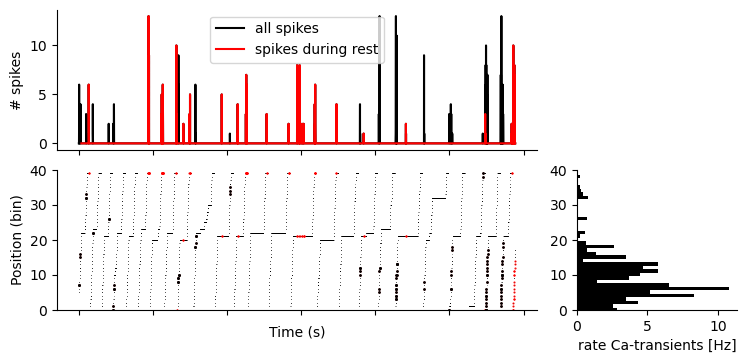

In [112]:
neuron_activity = ld["S"].copy()
activity = prepare_activity(neuron_activity[19, :], behavior, f=15.0, only_active=True)

# from placefield_detection.alternative_detection_methods import (
#     peak_method_batch,
#     information_method_batch,
#     stability_method

plot_activity(activity, behavior, f=f)

92.73 99.53


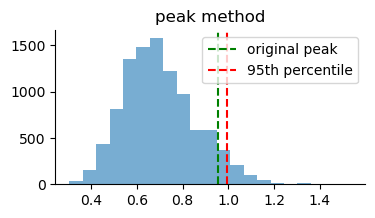

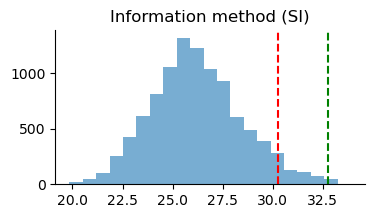

In [113]:
from placefield_detection.alternative_detection_methods import (
    peak_method,
    information_method,
)

neuron = 19
neuron_activity = ld["S"][:, behavior["active"]]
shuffles = 10000
is_pc, p_val = peak_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
is_pc, p_val_info = information_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
print(p_val, p_val_info)

In [127]:
from placefield_detection.alternative_detection_methods import (
    peak_method_batch,
    information_method_batch,
    # stability_method,
)

print(neuron_activity.shape)
# information_method(
#     behavior,
#     neuron_activity[0, :],
#     n_shuffles=10000,
#     plot=True,
# )

# results_info = information_method_batch(
#     behavior,
#     neuron_activity,
#     n_shuffles=10000,
# )
is_place_cell, p_value = peak_method_batch(
    behavior,
    neuron_activity,
    n_shuffles=10000,
)
# stability_method(
#     behavior,
#     neuron_activity,
#     neurons,
#     nbin,
# )

(853, 3050)


100%|██████████| 853/853 [00:50<00:00, 16.87it/s]


In [71]:
from placefield_detection.utils import (
    get_firingmap,
    estimate_stats_from_one_sided_process,
    obtain_significant_events_from_one_sided_process,
)

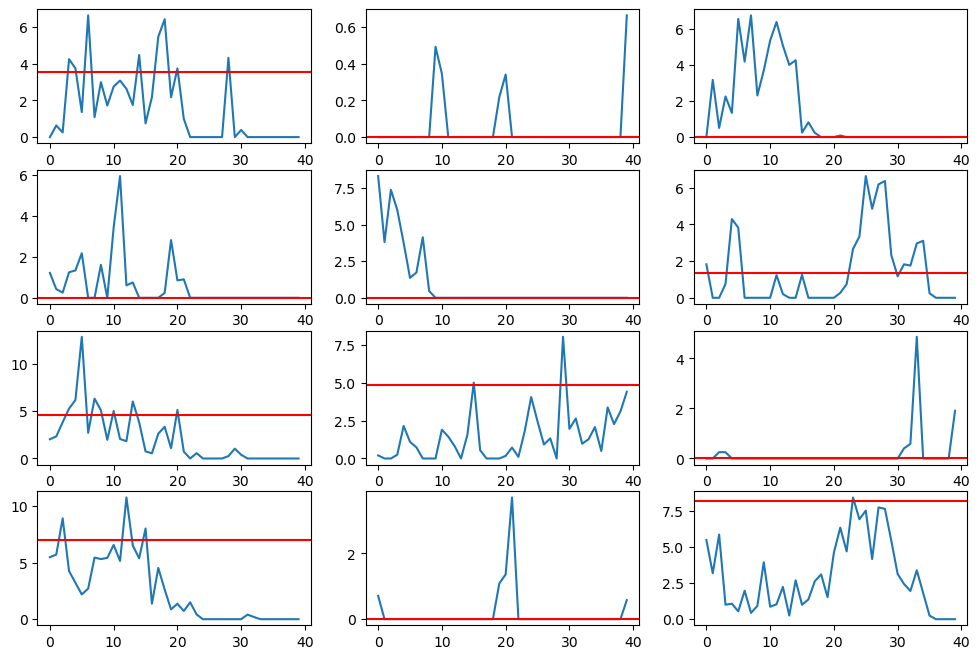

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(12, 8))

for neuron in range(12):

    activity = prepare_activity(
        neuron_activity[neuron, :], behavior, f=f, only_active=only_active
    )

    fmap = get_firingmap(
        activity["spikes"],
        behavior["position"],
        behavior["dwelltime"],
        nbin=behavior["nbin"],
    )
    # frate, threshold, _ = get_firingrate(neuron_activity[0,:],IQR=True)
    field, threshold, sd_r = obtain_significant_events_from_one_sided_process(
        fmap, baseline_mode="percentile", sd_mode="iqr", prctile=50
    )
    # print("sd_r:", sd_r)
    # baseline_prc, sd = estimate_stats_from_one_sided_process(fmap, "percentile", "iqr")
    # print("\n")
    # frate, threshold, PF = get_firingrate(fmap, sd_r=-1, IQR=False)
    # frate, threshold_IQR, PF = get_firingrate(fmap, sd_r=-1, IQR=True)

    ax = axes[neuron // 3, neuron % 3]
    ax.plot(fmap, label="firing map")
    ax.axhline(threshold, color="r", linestyle="-", label="threshold")
    # ax.axhline(baseline_prc, color="g", linestyle="-", label="baseline %")
    # ax.axhline(threshold + 2 * sd, color="r", linestyle="--", label="threshold SD")
    # ax.axhline(
    # baseline_prc + 2 * sd_iqr, color="g", linestyle="--", label="threshold SD"
    # )
    # ax.set_title(f"Neuron {neuron}")
    # print(threshold, "vs", threshold_IQR)
    # print(PF)

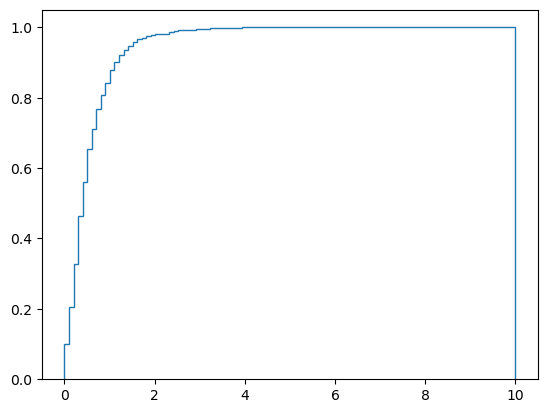

(array([], dtype=int64),)

In [83]:
# fig, axes = plt.subplots(10, 2, figsize=(8, 12))
import numpy as np

f = 15
frate = np.empty((neuron_activity.shape[0],))
# for i, neuron in enumerate(range(neuron_activity.shape[0])):
for i, neuron in enumerate(range(neuron_activity.shape[0])):

    activity = prepare_activity(
        neuron_activity[neuron, :], behavior, f=f, only_active=True
    )
    frate[neuron] = np.mean(activity["firing_rate"])
    # baseline, _ = estimate_stats_from_one_sided_process(
    #     neuron_activity[neuron, :],
    #     # baseline_mode="percentile",
    #     # prctile=50,
    #     baseline_mode="hsm",
    # )
    # activity = neuron_activity[neuron, :] / baseline
    # activity[np.logical_and(activity > 0, activity < 1)] = 1
    # # activity = np.floor(activity)
    # activity = np.floor(np.sqrt(activity))

    # frate[neuron] = np.mean(activity) * f

    # significant_events, threshold, _ = obtain_significant_events_from_one_sided_process(
    # 	neuron_activity[neuron, :],
    # 	baseline_mode="hsm",
    # 	sd_mode="iqr",
    # 	prctile=10,
    # 	sd_r=0,
    # )
    # print(activity)
# 	ax = axes[i][0]
# 	ax.plot(neuron_activity[neuron, :], label=f"Neuron {neuron}")
# 	ax.axhline(threshold, color="r", linestyle="--", label="threshold")

# 	ax = axes[i][1]
# 	ax.plot(activity, label=f"Neuron {neuron}")
# plt.show()

plt.figure()
plt.hist(
    frate, bins=np.linspace(0, 10, 100), cumulative=True, density=True, histtype="step"
)
plt.show()
np.where(frate > 20)

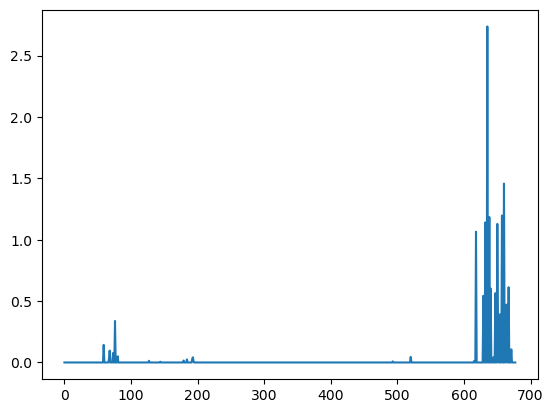

In [113]:
plt.figure()
plt.plot(neuron_activity[441, :], label="Neuron 0")
plt.show()

In [24]:
obtain_significant_events_from_one_sided_process(fmap)
# fmap

0.041249244347929544 sd from mad 


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 13.65949467,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.1825895 ]),
 0.17134708848849367,
 3.4794449072863864)

[[0.         0.         0.         ... 0.         0.04293704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02147177 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[       nan        nan        nan ...        nan 0.04293704        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan 0.02147177        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


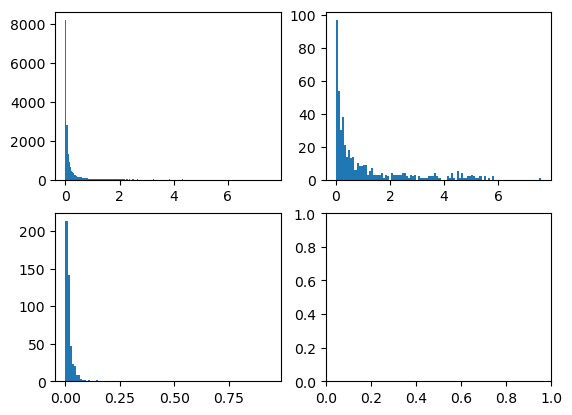

In [49]:
# activity =
import numpy as np

act_masked = np.ma.masked_array(neuron_activity, mask=neuron_activity == 0)
act_masked = np.ma.filled(act_masked, np.nan)
print(neuron_activity)
print(act_masked)
fig, axes = plt.subplots(2, 2)
axes[0][0].hist(neuron_activity[neuron_activity > 0], bins=200)
axes[0][1].hist(np.nanmax(act_masked, axis=1), bins=100)
axes[1][0].hist(np.nanpercentile(act_masked, 20, axis=1), bins=100)
plt.show()

In [13]:
neuron_activity.shape

(837, 38)

# test namras method

{'n_modes': 1,
 'baseline': 2.2092374455155754,
 'amplitude': [5.689292876451333],
 'location': [24.584912953914685],
 'width': [13.763408681001033]}

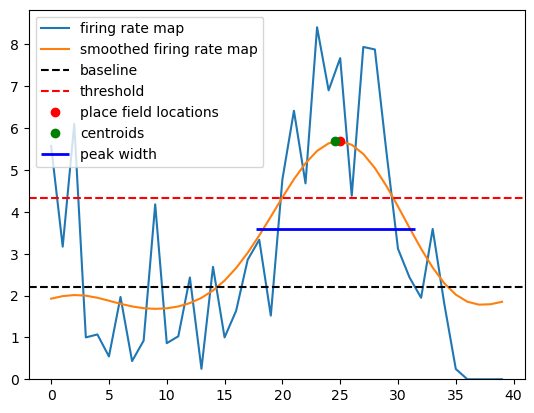

In [144]:
from placefield_detection.alternative_detection_methods.thresholding_pf_method import (
    thresholding_method_single,
    thresholding_method_batch,
)


# print(neuron_activity.shape)
# results = thresholding_method_single(behavior, ld["S"][3, :], plot=True)
results = thresholding_method_single(behavior, neuron_activity[11, :], plot=True)
results
# place_fields = thresholding_method_batch(behavior, neuron_activity, sigma=2)

In [ ]:
behavior["dwelltime"].shape

(40,)

{}


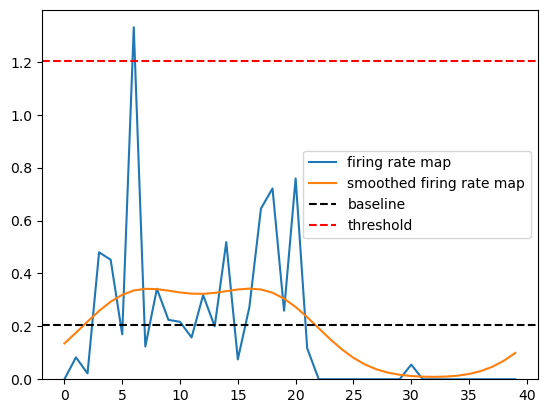

In [118]:
for neuron in range(1):
    field = thresholding_method_single(
        behavior, neuron_activity[neuron, :], threshold_factor=4, sigma=4, plot=True
    )
    print(field)
# field = thresholding_method_single(
#     behavior, neuron_activity[4, :], sigma=2, plot=True
# )
# field

In [119]:
place_fields

[{},
 {'n_modes': 2,
  'baseline': 0.0011346529300962234,
  'amplitude': [0.011125039031006596, 0.007691179281043191],
  'location': [9.527601564573878, 19.869045122135578],
  'width': [5.74855146609184, 5.113777256666271]},
 {'n_modes': 1,
  'baseline': 0.03393081632151772,
  'amplitude': [0.47805001908228395],
  'location': [8.599321178471726],
  'width': [13.558208087676421]},
 {},
 {'n_modes': 1,
  'baseline': 0.0003488903679443304,
  'amplitude': [0.23941290306799912],
  'location': [2.9658596965112025],
  'width': [8.160844946295022]},
 {},
 {},
 {},
 {'n_modes': 1,
  'baseline': 0.0016763737699805046,
  'amplitude': [0.10431981072273616],
  'location': [32.91430353078129],
  'width': [5.740765341055795]},
 {},
 {'n_modes': 1,
  'baseline': 0.002323888049402604,
  'amplitude': [0.04082046744490164],
  'location': [19.468802850101113],
  'width': [5.738851480292514]},
 {},
 {},
 {},
 {'n_modes': 1,
  'baseline': 0.00019819537853193837,
  'amplitude': [0.12956268255077924],
  'loca